# Signal Metrics API

In this notebook we will explore extracting metrics from Nanopore signal anchored to basecalls or reference bases.
This can be used to explore modified bases and provides a common framework for developing Nanopore signal analysis tools.

#### Imports

In [1]:
import logging
from pathlib import Path

import pod5
import pysam
import numpy as np
import polars as pl
import plotnine as p9
import patchworklib as pw
from scipy.stats import ttest_ind

import remora
from remora import io, refine_signal_map, util

# silence Remora DEBUG messages
logging.getLogger("Remora").setLevel(logging.INFO)

p9.theme_set(p9.theme_minimal() + p9.theme(figure_size=(10, 3)))

<Figure size 100x100 with 0 Axes>

## Data and Level Table Loading

Load test data as shown in `basic_read_plotting` and `signal_mapping_refinement` notebooks. 
Note the `scale_iters=0` setting indicating that signal to sequence mapping (re-squiggling) is performed.
Setting `scale_iter=-1` would extract metrics against the move table assigned positions.
This is generally less useful, but it possible within the Remora framework.

For examples in this notebook we will load two different samples.
The canonical (`can`) sample is a PCR experiment; all nucleotides should be canonical.
The modified (`mod`) sample is treated with the bacterial methylase M.SssI resulting in all cytosine bases in a `CG` sequence context being converted to a 5-methylcytosine.
This is an ideal sample to observe signal differences in the presence of a modified base.
This data type is part of the training data for the released 5mC Remora models.

In [2]:
test_data_root = Path("..") / "tests" / "data"
pod5_dr = pod5.DatasetReader(test_data_root)
can_bam_fh = io.ReadIndexedBam(test_data_root / "can_mappings.bam")
mod_bam_fh = io.ReadIndexedBam(test_data_root / "mod_mappings.bam")

level_table = test_data_root / "levels.txt"
sig_map_refiner = refine_signal_map.SigMapRefiner(
    kmer_model_filename=level_table,
    do_rough_rescale=True,
    scale_iters=0,
    do_fix_guage=True,
)

Indexing BAM by parent read id: 14 Reads [00:00, 3907.13 Reads/s]
Indexing BAM by parent read id: 14 Reads [00:00, 4938.63 Reads/s]


## Basecall-anchored Metrics

We will start with extracting metrics anchored to the basecalls of a single read.
The `remora.io.read` is loaded as shown in the previous notebooks from a pod5 and a pysam read object.
Next the signal to sequence mapping is refined using the loaded signal mapping refiner object.

In [3]:
read_id = "6e37823a-9398-4be8-b111-65cab029f4e0"
pod5_read = pod5_dr.get_read(read_id)
bam_read = can_bam_fh.get_first_alignment(read_id)
io_read = io.Read.from_pod5_and_alignment(pod5_read, bam_read)
io_read.set_refine_signal_mapping(sig_map_refiner, ref_mapping=False)

Next metrics are extract from the read.
First the expected levels are extracted using the basecalled sequence (`io_read.seq`).
Next the "mean" and "trimmean" metrics are computed for this read via the `compute_per_base_metric` method.
The first argument to `io_read.compute_per_base_metric` is a string representing several common metrics.

These common metrics are:
* `dwell`
  * Number of sample points assigned to a base.
* `mean`
  * Mean of signal points assigned to a base.
* `sd`
  * Standard deviation of signal points assigned to a base.
* `trimmean`
  * Mean of signal points assigned to this base after trimming a fixed number of signal points from the start and end of the base.
    * The number of signal points trimmed is set via the `st_trim` and `en_trim` keyword arguments. These can be passed directly to the `io_read.compute_per_base_metric` method.
  * Trimming produces more robust metric values due to transition signal points being included in either of the neighboring bases.
* `trimsd`
  * Standard deviation after trimming procedure descried above.

Since multiple metrics can be computed together more efficiently, default string values are joined with an underscore (`_`).
Thus to get the dwell, trim mean and trim SD, the string value would be `dwell_trimmean_trimsd`.
The full list of preset string metrics can be found in the `remora.metrics.METRIC_FUNCS` object.

In [4]:
model_levels = sig_map_refiner.extract_levels(util.seq_to_int(io_read.seq))
read_levels = io_read.compute_per_base_metric("dwell_mean", ref_anchored=False)[
    "mean"
]
trim_read_levels = io_read.compute_per_base_metric(
    "dwell_trimmean", ref_anchored=False
)["trimmean"]

These metrics can then be visualized alongside the signal values.

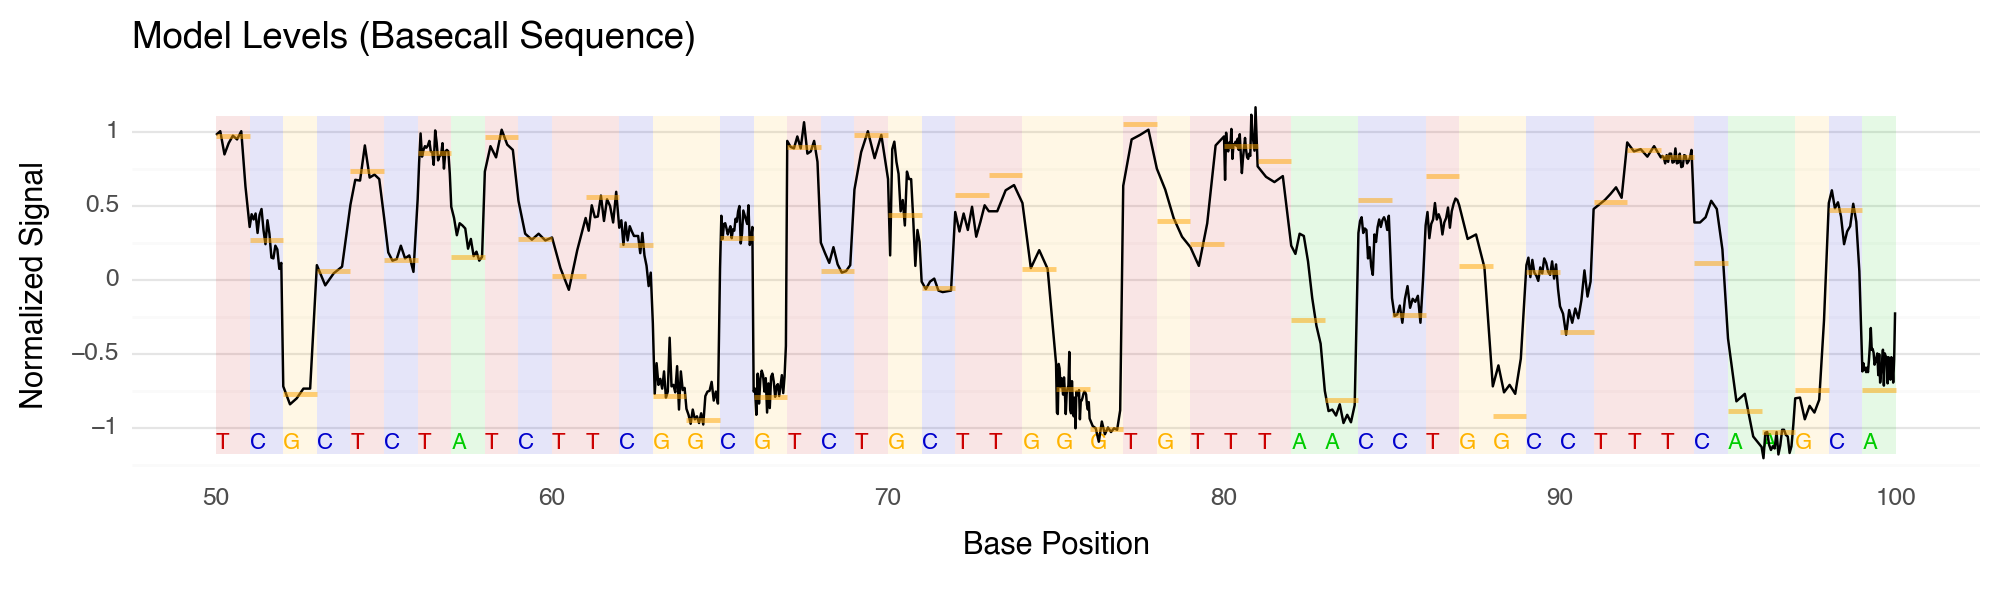

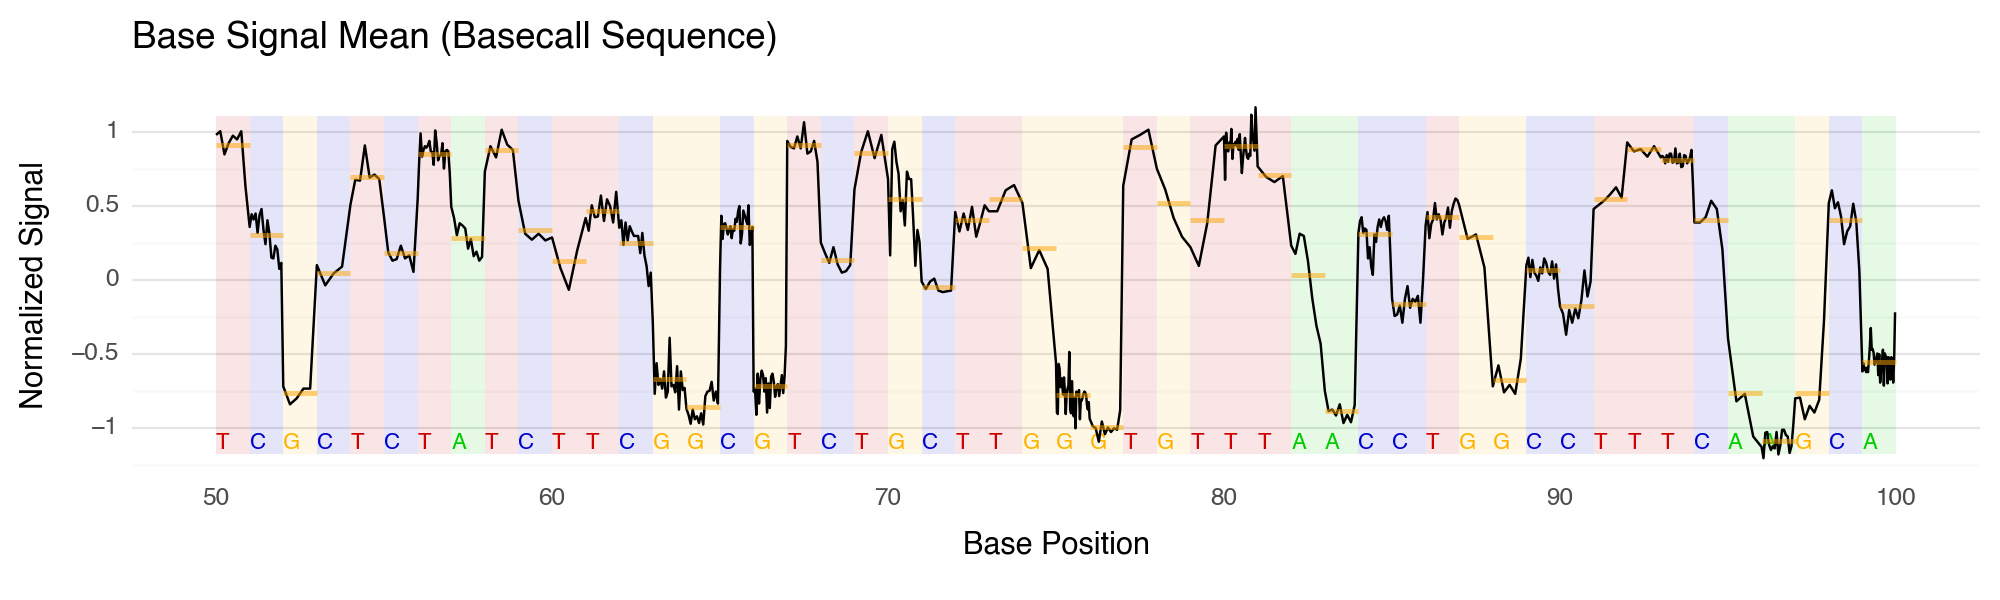

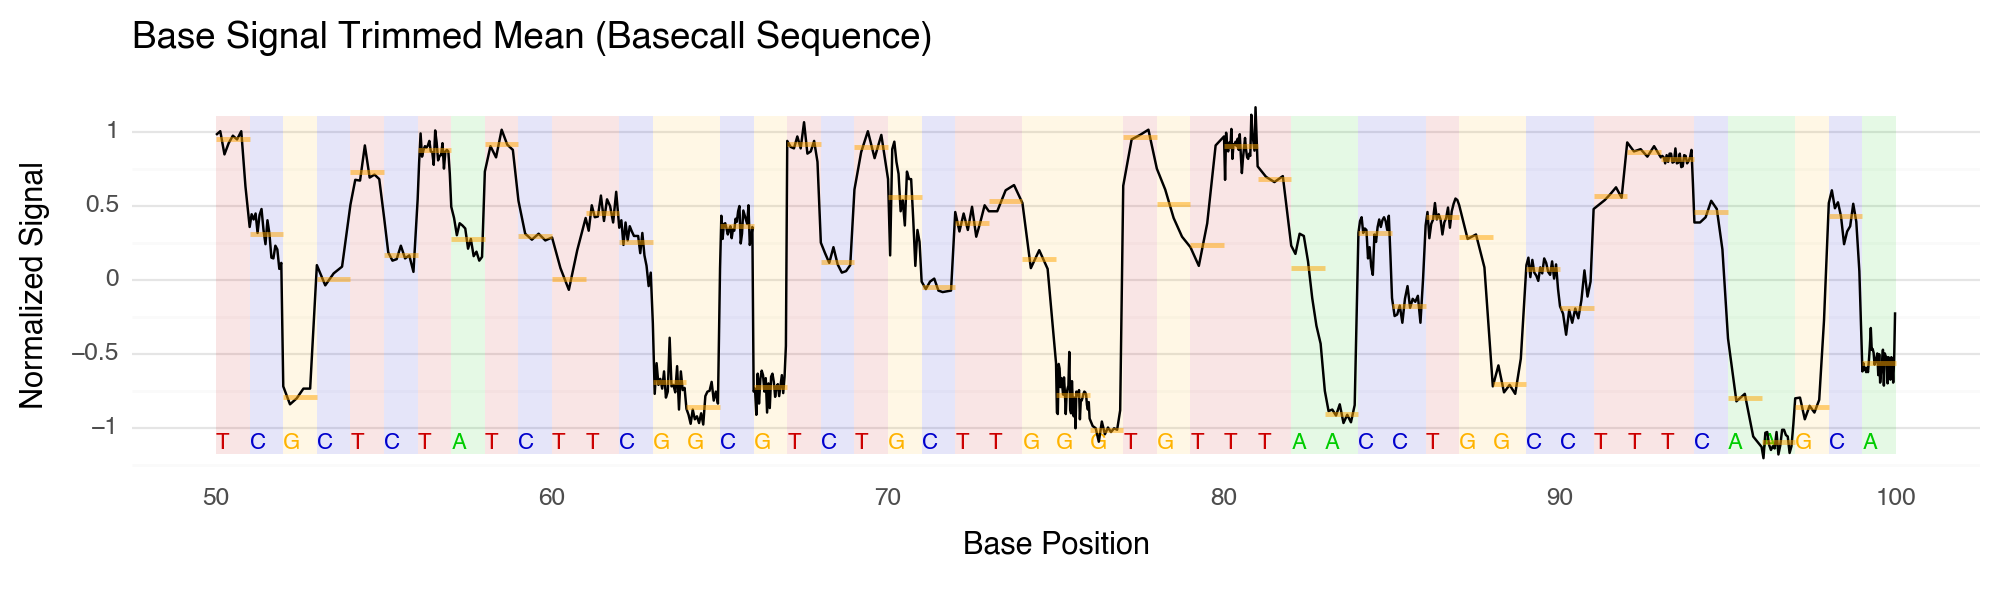

In [5]:
start_base, end_base = 50, 100
read_bc_reg = io_read.extract_basecall_region(start_base, end_base)

print(
    read_bc_reg.plot_on_base_coords(levels=model_levels[start_base:end_base])
    + p9.ggtitle("Model Levels (Basecall Sequence)")
)
print(
    read_bc_reg.plot_on_base_coords(levels=read_levels[start_base:end_base])
    + p9.ggtitle("Base Signal Mean (Basecall Sequence)")
)
print(
    read_bc_reg.plot_on_base_coords(
        levels=trim_read_levels[start_base:end_base]
    )
    + p9.ggtitle("Base Signal Trimmed Mean (Basecall Sequence)")
)

#### Plot Dwell and SD Metrics

The returned metrics can be used in a number of ways.
Show in the next cell is an example plotting the dwell, trim mean and trim SD for a section of a read.

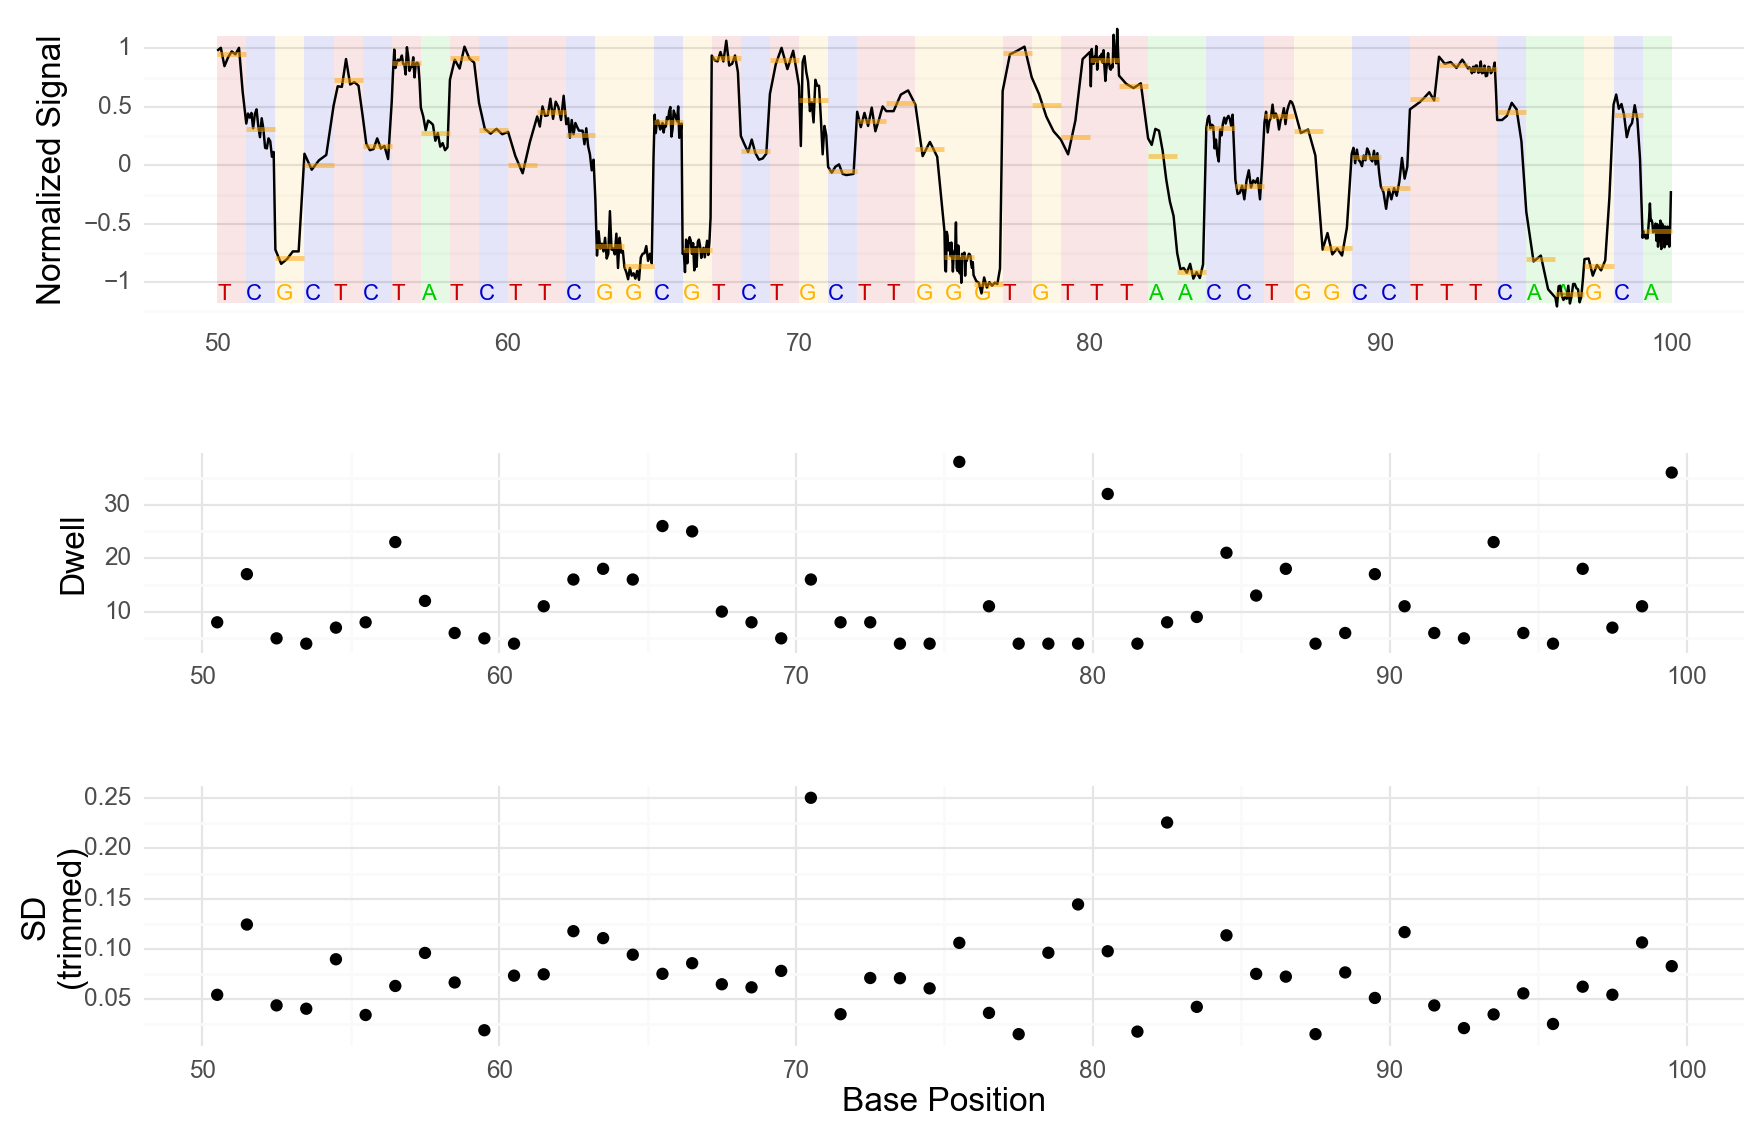

In [6]:
read_bc_reg = io_read.extract_basecall_region(start_base, end_base)
read_metrics = io_read.compute_per_base_metric(
    "dwell_trimmean_trimsd", ref_anchored=False
)

pw.load_ggplot(
    read_bc_reg.plot_on_base_coords(
        levels=read_metrics["trimmean"][start_base:end_base]
    )
    + p9.theme(figure_size=(8, 1.5))
    + p9.xlab("")
) / pw.load_ggplot(
    p9.ggplot()
    + p9.geom_point(
        p9.aes(
            x=np.arange(start_base, end_base) + 0.5,
            y=read_metrics["dwell"][start_base:end_base],
        )
    )
    + p9.theme(figure_size=(8, 1))
    + p9.ylab("Dwell")
) / pw.load_ggplot(
    p9.ggplot()
    + p9.geom_point(
        p9.aes(
            x=np.arange(start_base, end_base) + 0.5,
            y=read_metrics["trimsd"][start_base:end_base],
        )
    )
    + p9.theme(figure_size=(8, 1.3))
    + p9.ylab("SD\n(trimmed)")
    + p9.xlab("Base Position")
)

## Custom Metrics

In addition to the preset string metrics, the metrics API allows the computation of arbitrary metrics.
The `metric_func` argument to `io_read.compute_per_base_metric` accepts a python function accepting the signal and a sequence to signal mapping as the first two positional arguments.
Additional keyword arguments can also be defined for custom metric functions and passed directly to the `io_read.compute_per_base_metric` method.
The custom function should return a dict of metric names to per base metric arrays.
As a toy example we re-implement the dwell metric with the following code.

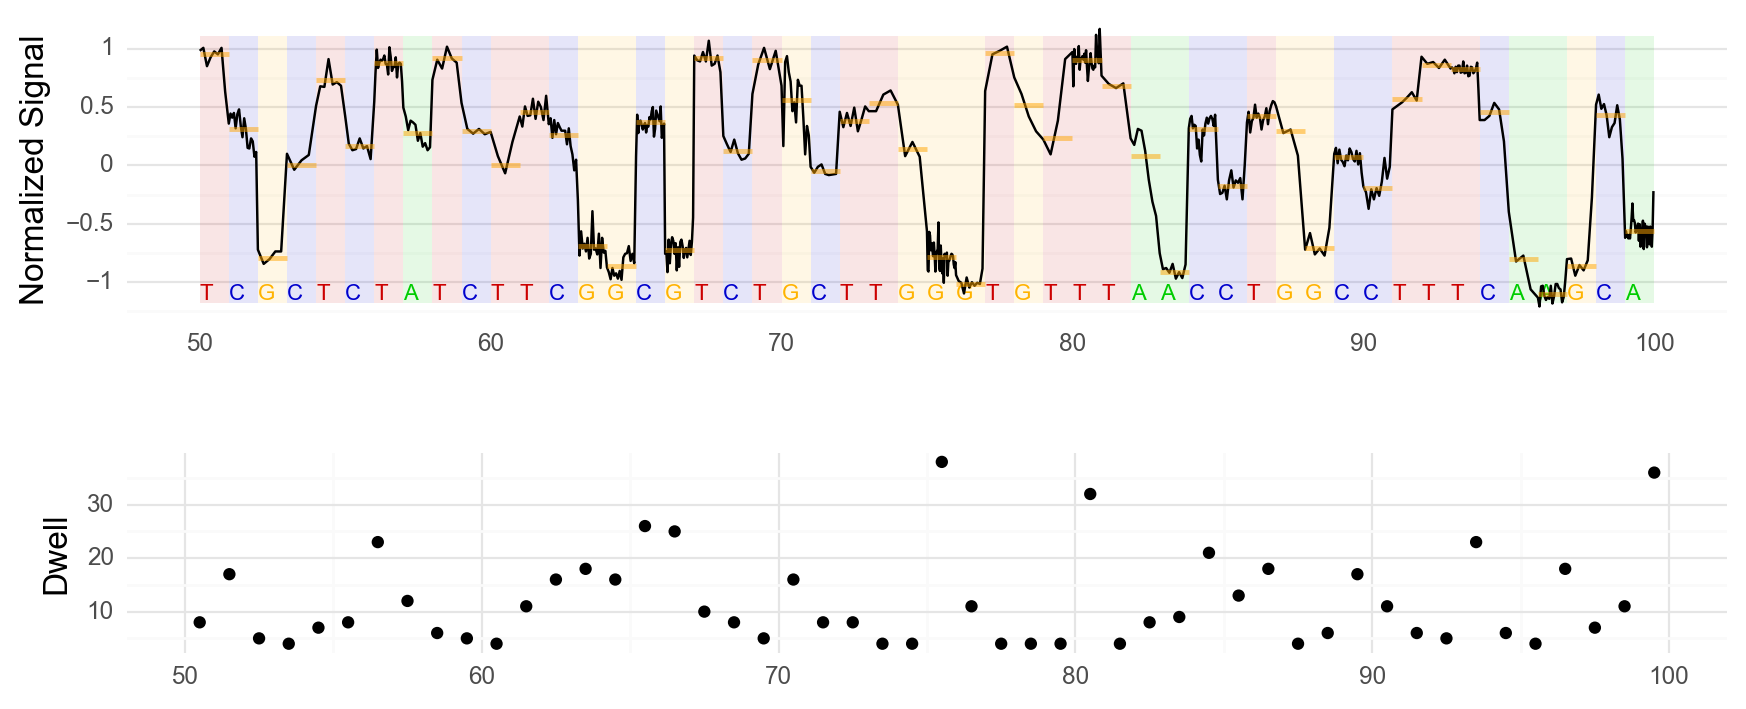

In [7]:
def dwell(sig, seq_to_sig):
    return {"dwell": np.diff(seq_to_sig).astype(np.float32)}


base_dwells = io_read.compute_per_base_metric(
    metric_func=dwell, ref_anchored=False
)["dwell"]

pw.load_ggplot(
    read_bc_reg.plot_on_base_coords(
        levels=read_metrics["trimmean"][start_base:end_base]
    )
    + p9.theme(figure_size=(8, 1.5))
    + p9.xlab("")
) / pw.load_ggplot(
    p9.ggplot()
    + p9.geom_point(
        p9.aes(
            x=np.arange(start_base, end_base) + 0.5,
            y=base_dwells[start_base:end_base],
        )
    )
    + p9.theme(figure_size=(8, 1))
    + p9.ylab("Dwell")
)

## Reference-anchored Metrics

In addition to basecall anchored signal metrics, Remora also enables extraction of reference anchored signal metrics.
These are extracted in much the same way as the basecall anchored metrics with the `ref_anchored=True` argument.

#### Single Read Plotting

The next cell shows an example snippet extracting reference anchored metrics and plotting these metrics.

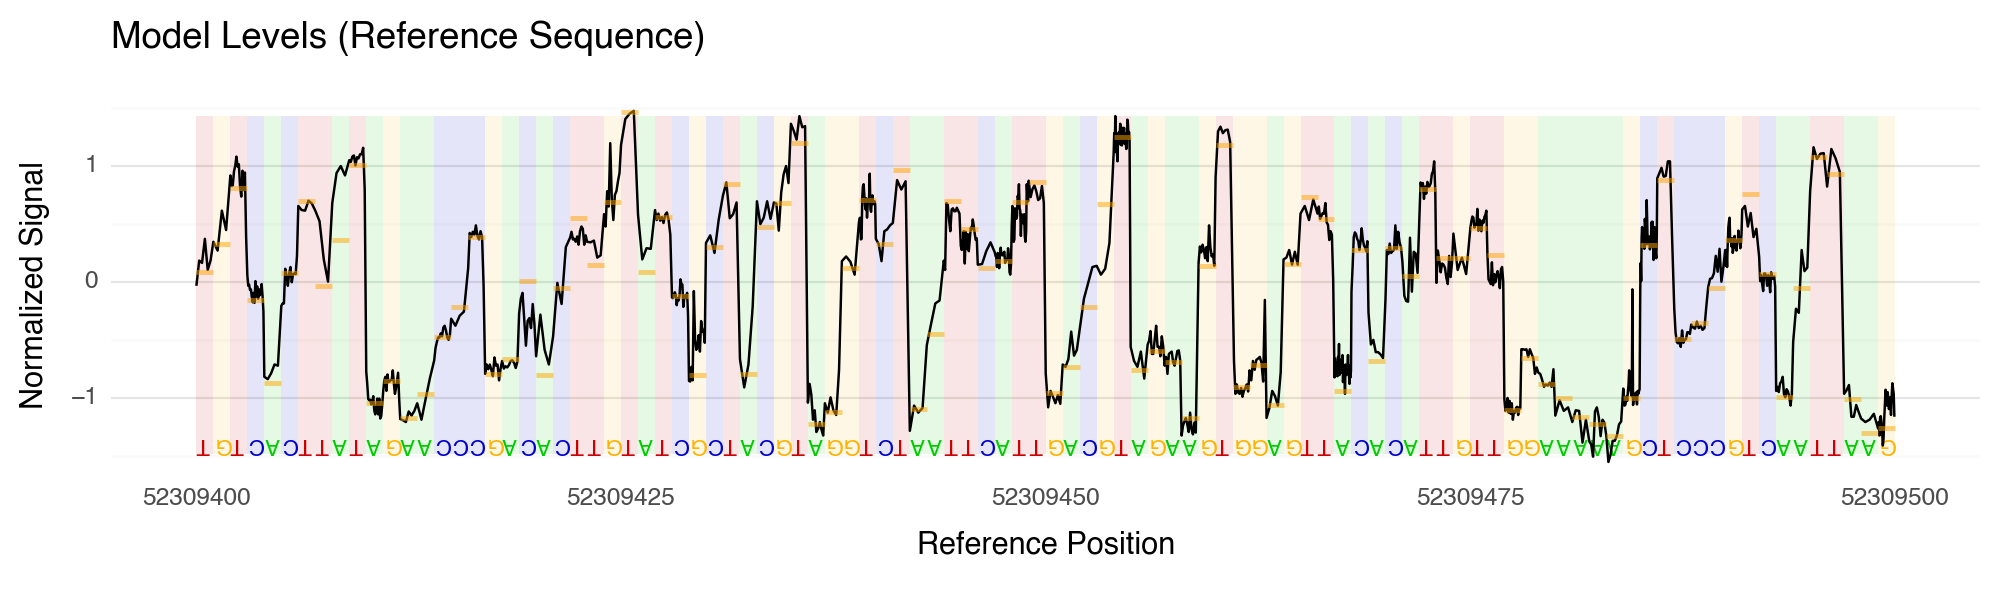

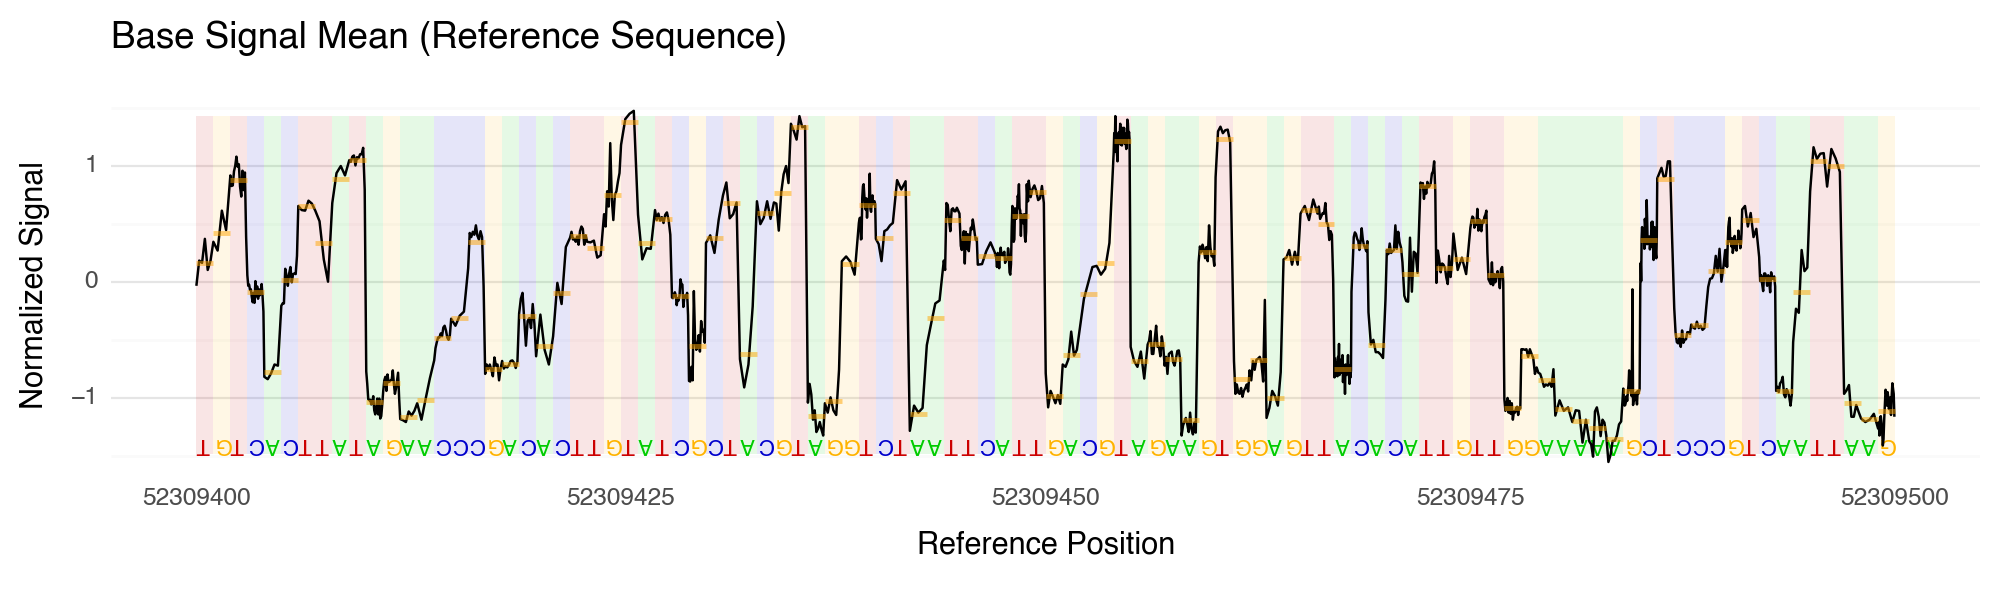

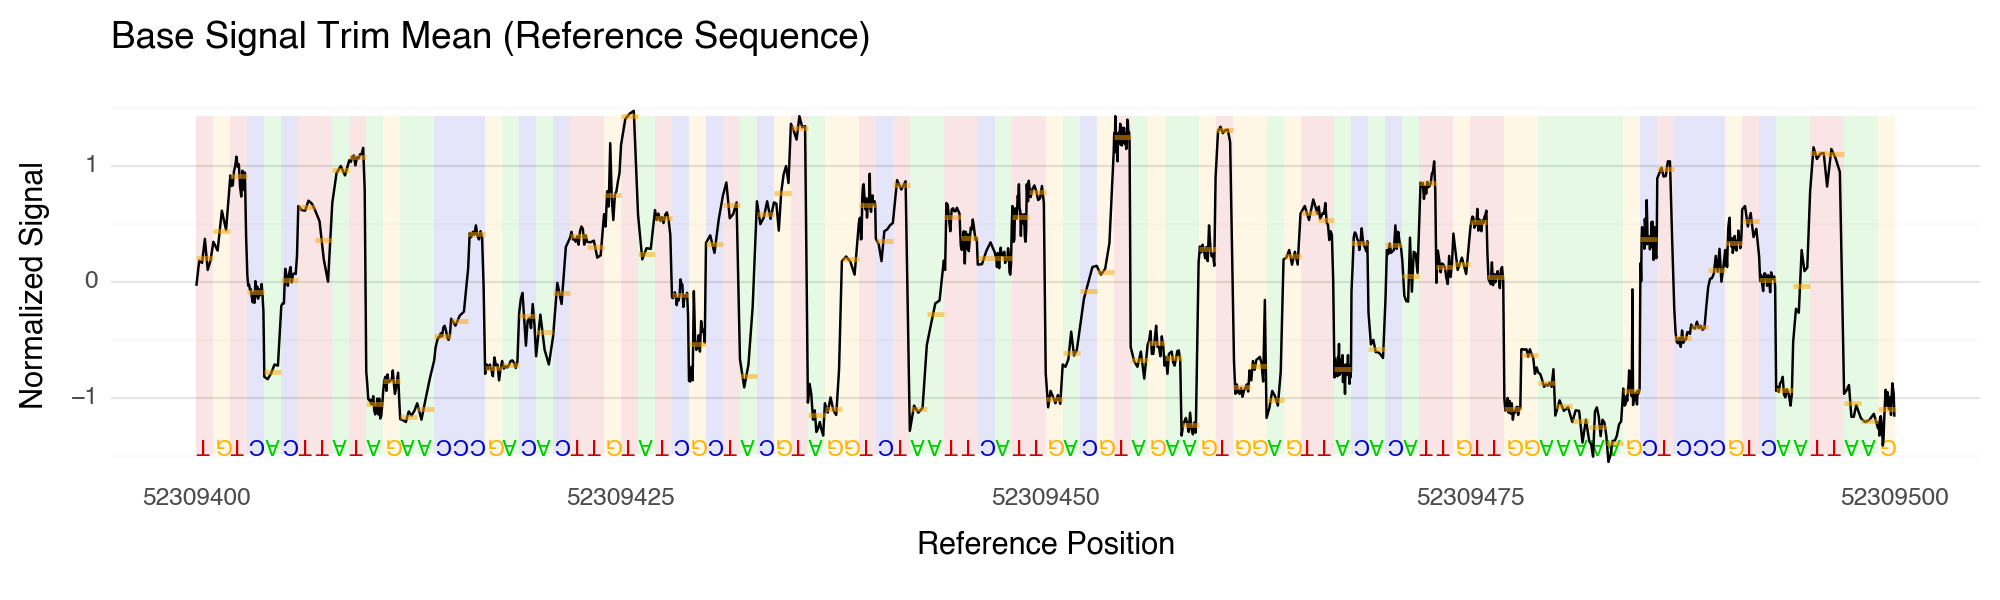

In [8]:
# example read is reverse strand
ref_reg = io.RefRegion(
    ctg=io_read.ref_reg.ctg,
    strand=io_read.ref_reg.strand,
    start=52_309_400,
    end=52_309_500,
)

io_read.set_refine_signal_mapping(sig_map_refiner, ref_mapping=True)

_, model_levels = io.get_ref_seq_and_levels_from_reads(
    ref_reg, [bam_read], sig_map_refiner, ref_orient=True
)
read_means = io_read.compute_per_base_metric(
    "dwell_mean", ref_anchored=True, region=ref_reg
)["mean"][::-1]
read_trim_means = io_read.compute_per_base_metric(
    "dwell_trimmean", ref_anchored=True, region=ref_reg
)["trimmean"][::-1]

read_ref_reg = io_read.extract_ref_reg(ref_reg)
print(
    read_ref_reg.plot_on_base_coords(levels=model_levels)
    + p9.ggtitle("Model Levels (Reference Sequence)")
)
print(
    read_ref_reg.plot_on_base_coords(levels=read_means)
    + p9.ggtitle("Base Signal Mean (Reference Sequence)")
)
print(
    read_ref_reg.plot_on_base_coords(levels=read_trim_means)
    + p9.ggtitle("Base Signal Trim Mean (Reference Sequence)")
)

## Multiple Reads at Reference Region

Reference anchored signal mappings and related metrics enable aggregation across reads.

#### Raw Signal Plotting

The next cell shows how to plot raw signal from reads covering a region of the reference.
The `io.plot_signal_at_ref_region` function combines the read extraction, signal refinement and plotting into one simple function.
Some options are made available, but users interested in more advanced functionality are encouraged to use the parts of this API most applicable to their research questions.

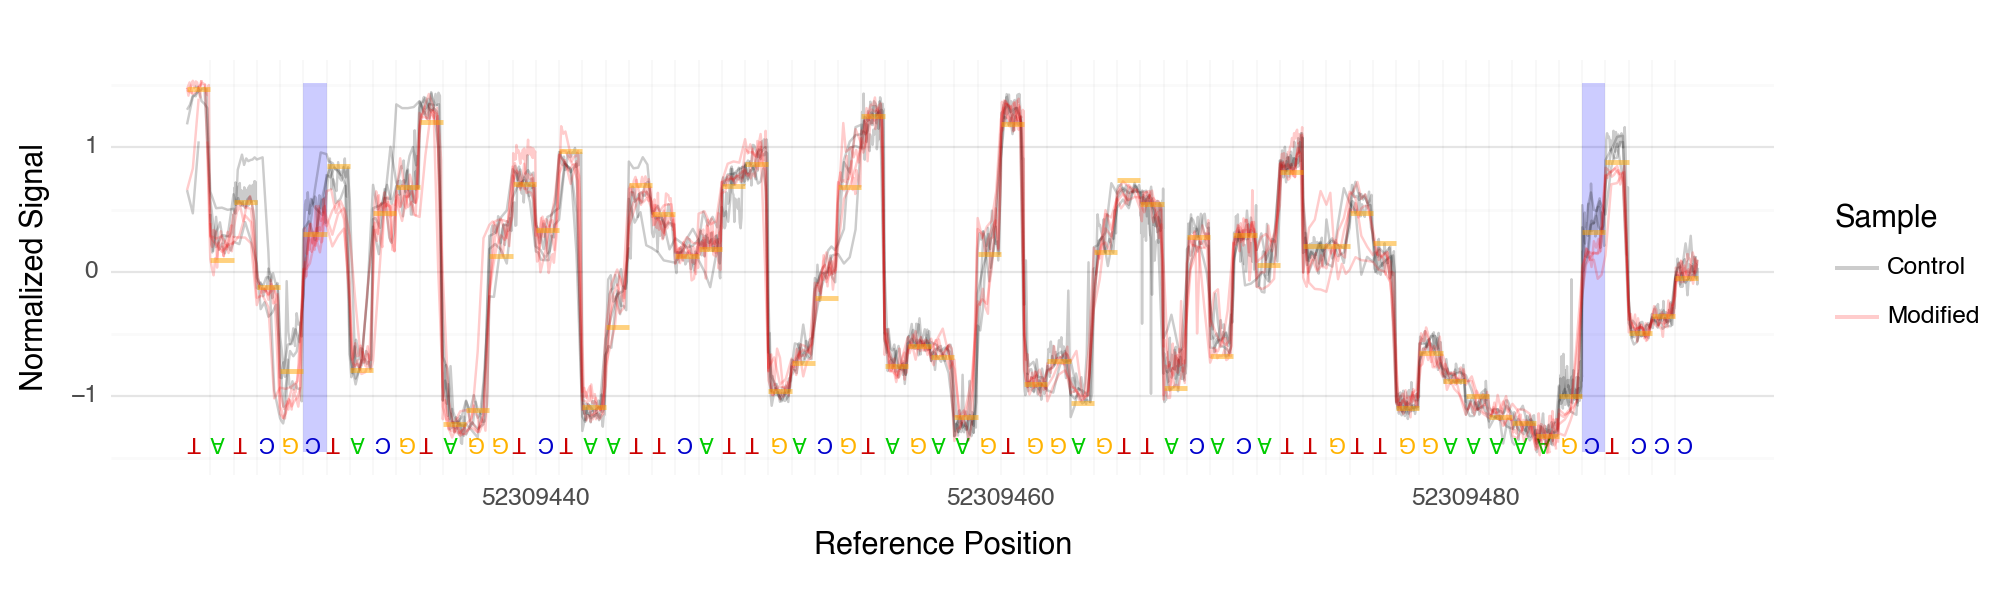

In [9]:
ref_reg = io.RefRegion(
    ctg="chr13", strand="-", start=52_309_425, end=52_309_490
)
ref_seq = io.get_ref_seq_from_reads(
    ref_reg, io.get_reg_bam_reads(ref_reg, can_bam_fh)
)
# search for GC positions since reads are on reverse strand
cg_locs = [
    (ref_reg.start + offset + 1, ref_reg.start + offset + 2, "blue")
    for offset in range(len(ref_seq) - 1)
    if ref_seq[offset : offset + 2] == "GC"
]
print(
    io.plot_signal_at_ref_region(
        ref_reg,
        [(pod5_dr, can_bam_fh), (pod5_dr, mod_bam_fh)],
        sig_map_refiner,
        highlight_ranges=cg_locs,
        sample_names=["Control", "Modified"],
        sample_colors=["black", "red"],
    )
)

#### Reference Region Metric Extraction

The next cells shows the commands to extract several metrics from reads covering a reference region.
As for the above plotting raw signal function, this function extracts reads, performs signal mapping refinement and computes relevant metrics.

Note that reads not covering the entire region are padded with `np.NAN` values to return a rectangular (not ragged) array.
This allows computation of statistics over columns of the array representing reference positions, but may lead to large memory consumption for large reference regions.
Note that computing this array may also be slow for very high coverage or very long regions.
On the other hand if a user aims to compute metrics over many neighboring or overlapping regions, the signal mapping refinement will be performed on each read for each call to this method.
Considerations should be taken when scaling this method over large datasets.

In [10]:
samples_metrics, all_bam_reads = io.get_ref_reg_samples_metrics(
    ref_reg,
    [(pod5_dr, can_bam_fh), (pod5_dr, mod_bam_fh)],
    metric="dwell_trimmean_trimsd",
    sig_map_refiner=sig_map_refiner,
)
print(f"Metrics computed: {', '.join(samples_metrics[0].keys())}")

# 4 reads, by 65 reference bases
# samples_metrics contains one item for each input sample
# each sample contains a dictionary with metric names pointing to numpy arrays
print(f"Shape of metric array: {samples_metrics[0]['trimmean'].shape}")

Metrics computed: dwell, trimmean, trimsd
Shape of metric array: (4, 65)


#### Reference Region Metric Plotting

The next cell shows how the `io.plot_metric_at_ref_region` function can be used to plot the distribution of signal metrics at a reference region.
Plotting is performed with the `plotnine` python library.
The default geometry for plotting is a boxplot, but alternative geometries can be supplied to the function if desired by the user.
See the plotnine documentation for more details.

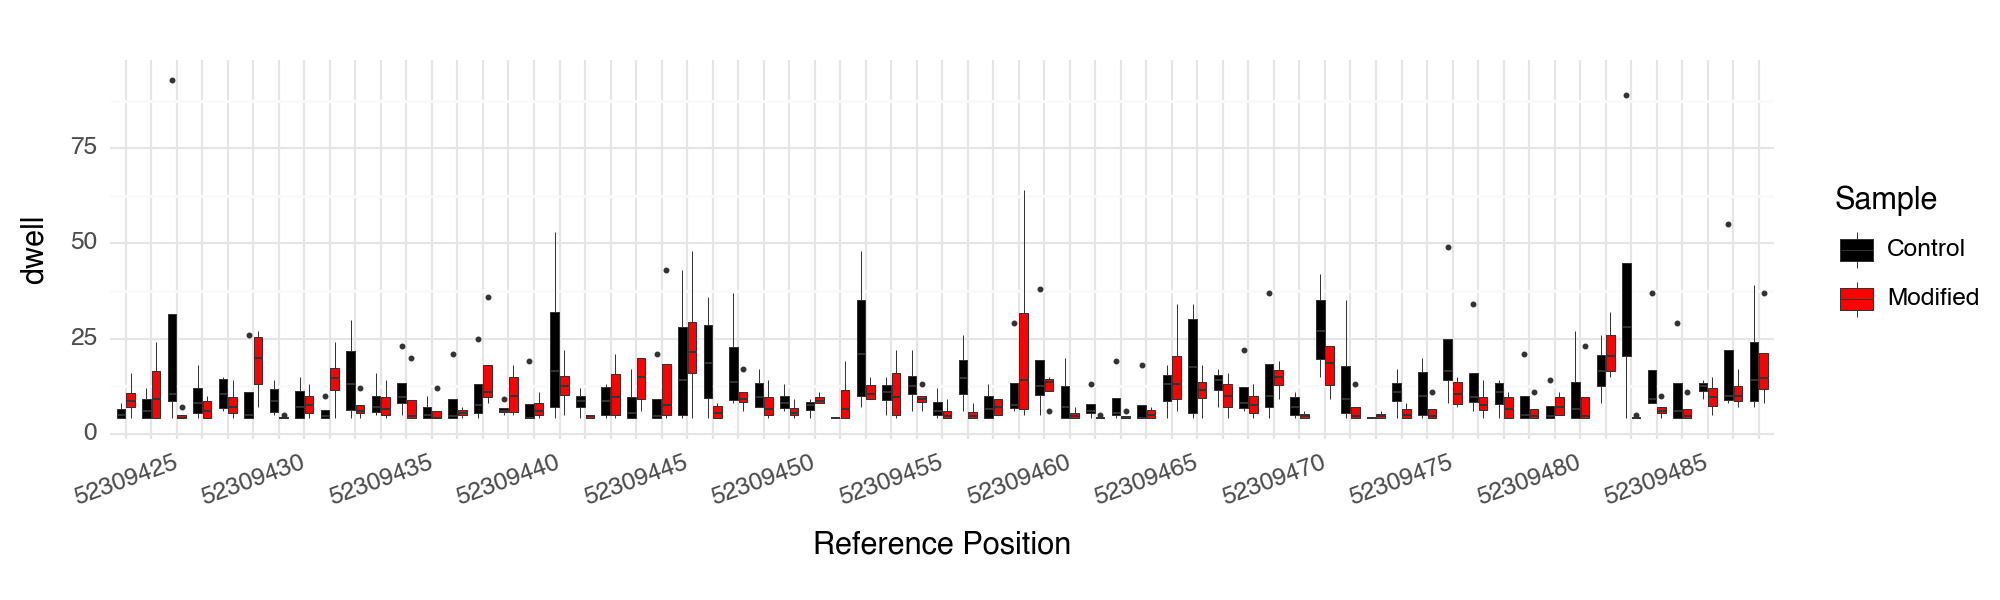

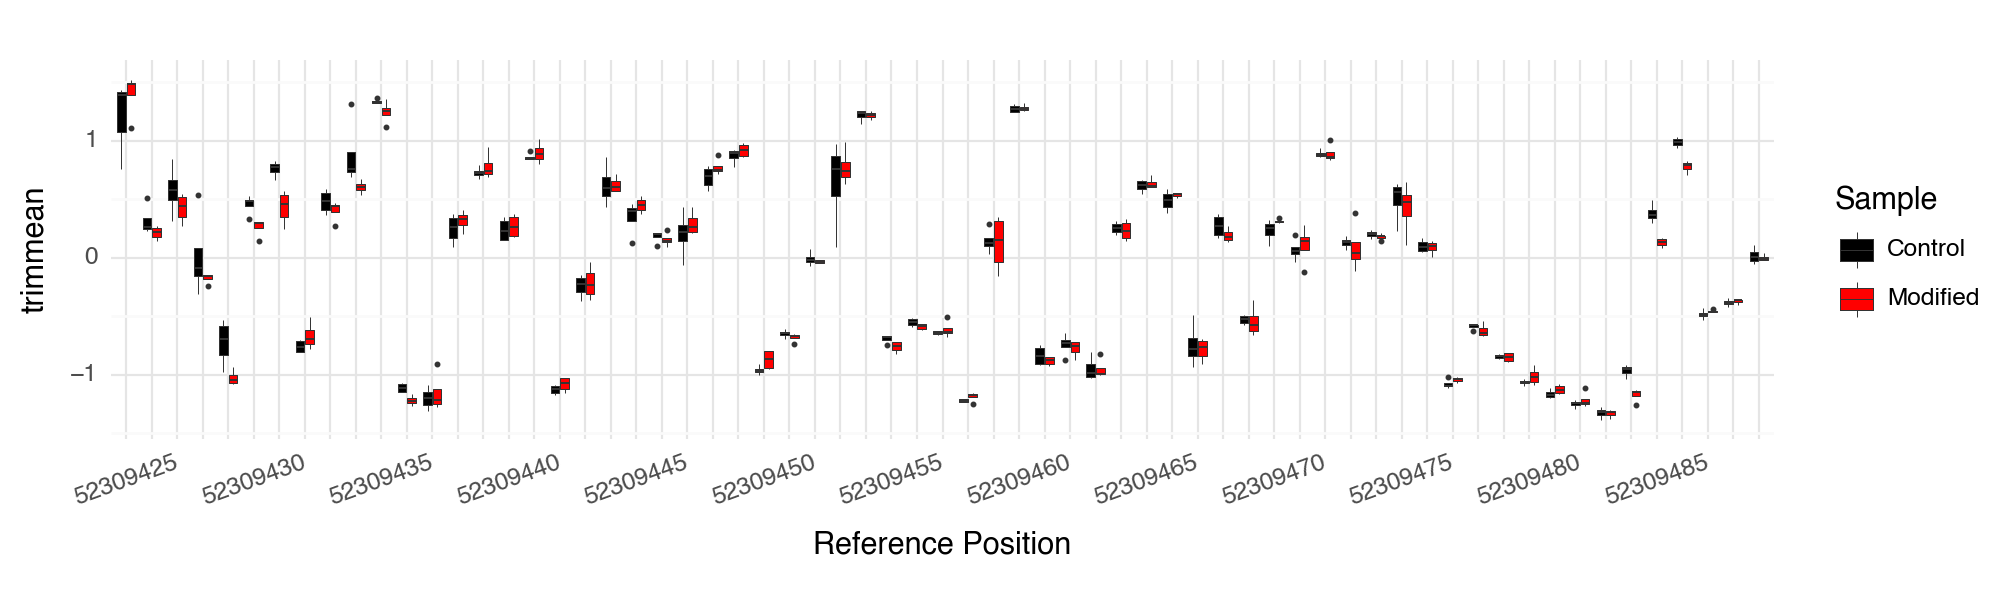

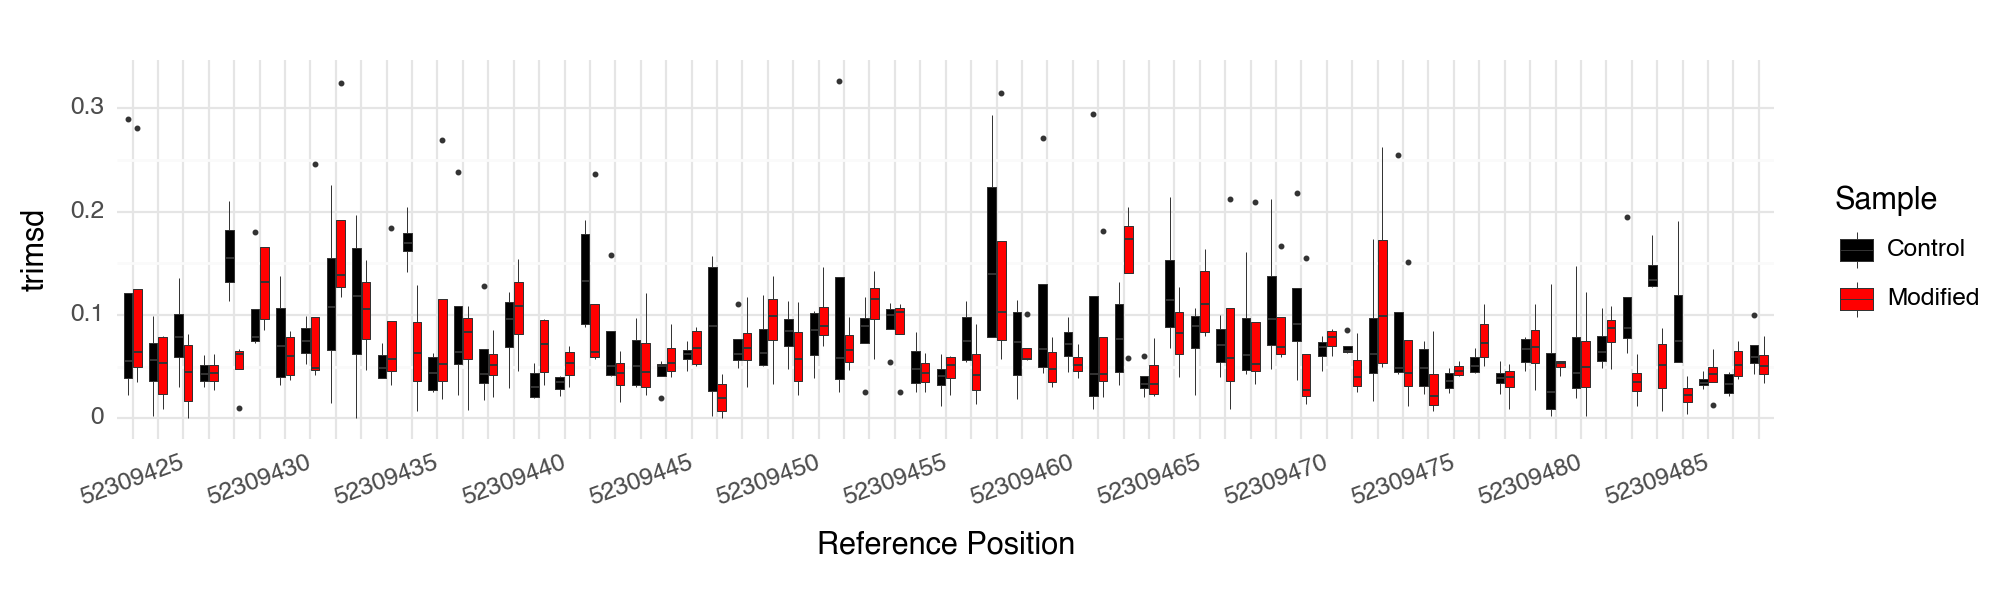

In [11]:
for p in io.plot_metric_at_ref_region(
    ref_reg,
    [(pod5_dr, can_bam_fh), (pod5_dr, mod_bam_fh)],
    sig_map_refiner=sig_map_refiner,
    metric="dwell_trimmean_trimsd",
    sample_names=["Control", "Modified"],
    sample_colors=["black", "red"],
    geom_kwargs={"size": 0.2, "outlier_size": 0.2},
):
    print(p + p9.theme(axis_text_x=p9.element_text(angle=20)))

## T-test p-values

The power of the Remora metrics API is enabling downstream analyses.
The next cell shows a simple analysis computing a t-test p-value for difference in signal mean between the two samples.
While this is a simple example it is shown in the resulting plot that signal difference peak around the modified bases in this region.

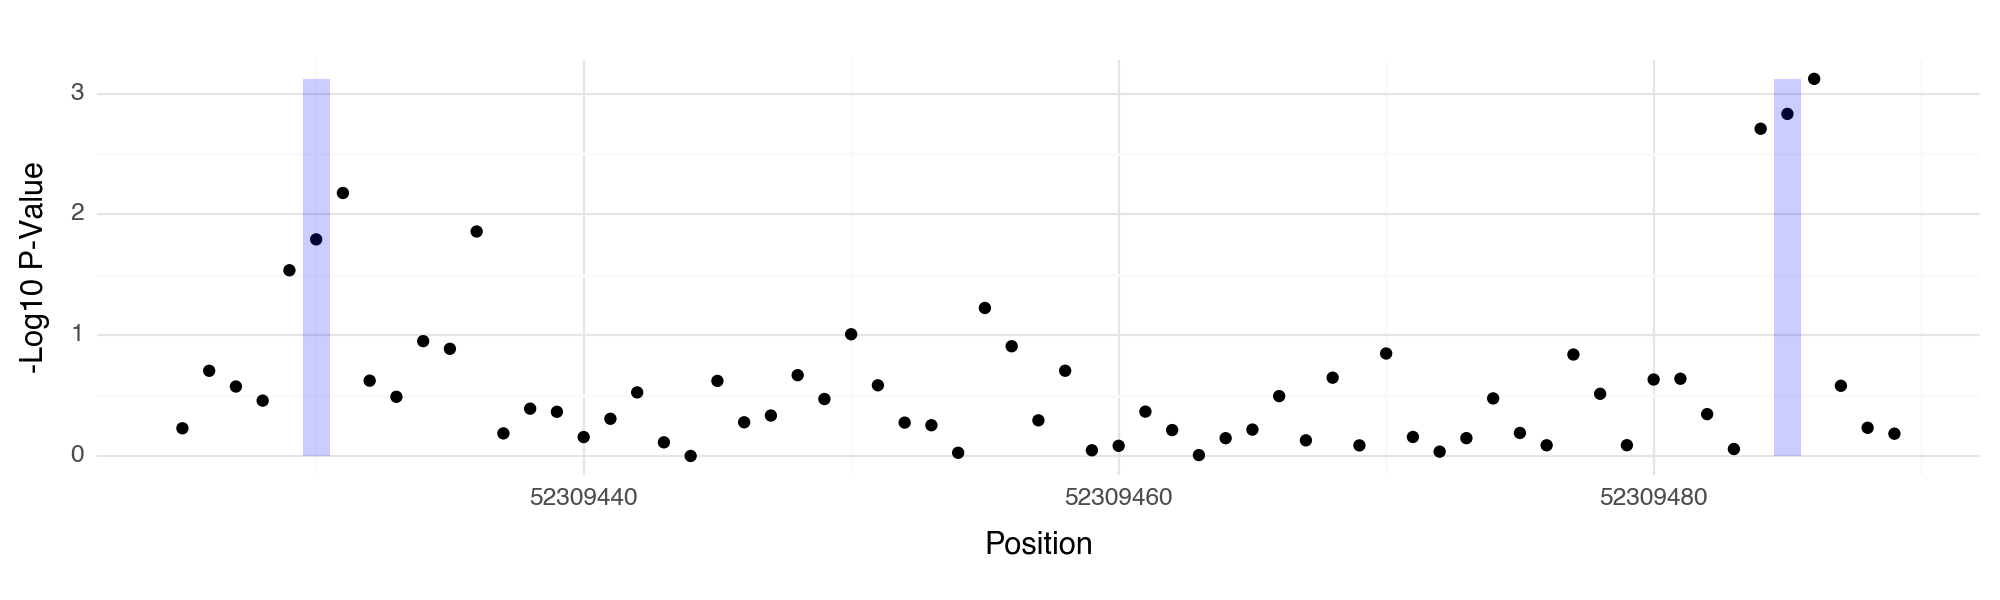

In [12]:
def nan_ttest(s1, s2):
    return -np.log10(ttest_ind(s1[~np.isnan(s1)], s2[~np.isnan(s2)]).pvalue)


ttest_df = pl.DataFrame(
    {
        "-Log10 P-Value": [
            nan_ttest(
                samples_metrics[0]["trimmean"][:, idx],
                samples_metrics[1]["trimmean"][:, idx],
            )
            for idx in range(ref_reg.len)
        ],
        "Position": ref_reg.coord_range,
    }
)
highlight_df = pl.DataFrame(
    cg_locs,
    schema=["start", "end", "color"],
    orient="row",
).with_columns(
    pl.col("start") - 0.5,
    pl.col("end") - 0.5,
)
print(
    p9.ggplot(ttest_df)
    + p9.geom_point(p9.aes(x="Position", y="-Log10 P-Value"))
    + p9.geom_rect(
        p9.aes(
            xmin="start",
            xmax="end",
        ),
        ymin=0,
        ymax=ttest_df["-Log10 P-Value"].max(),
        # keep fill out of legends (in case fill is used later)
        fill=highlight_df["color"],
        data=highlight_df,
        alpha=0.2,
    )
    + p9.scale_fill_manual(dict((c, c) for _, _, c in cg_locs))
)

## Text Output

The Remora metrics API does not provide a direct text output format.
This section gives an example outputting simple metrics in a tabular format.
This output could be extended to include any other related information including basecall sequence, reference sequence, read or alignment statistics.
The extension of this text output is left to the user.

In [13]:
def iter_metrics(samp_names, samples_metrics, all_bam_reads, ref_reg):
    for samp_name, samp_metrics, samp_bam_reads in zip(
        samp_names, samples_metrics, all_bam_reads
    ):
        for metric, reads_metrics in samp_metrics.items():
            for bam_read, read_metrics in zip(samp_bam_reads, reads_metrics):
                for reg_pos, metric_value in enumerate(read_metrics):
                    if np.isnan(metric_value):
                        print("is nan")
                        continue
                    yield samp_name, bam_read.query_name, reg_pos + ref_reg.start, metric, metric_value


num_rows = 0
max_rows = 10
print("Sample\tRead_id\tReference_Position\tMetric\tValue")
for metric_row in iter_metrics(
    ("Control", "Modified"), samples_metrics, all_bam_reads, ref_reg
):
    print("\t".join(map(str, metric_row)))
    num_rows += 1
    if num_rows >= max_rows:
        break

Sample	Read_id	Reference_Position	Metric	Value
Control	6e37823a-9398-4be8-b111-65cab029f4e0	52309425	dwell	4.0
Control	6e37823a-9398-4be8-b111-65cab029f4e0	52309426	dwell	4.0
Control	6e37823a-9398-4be8-b111-65cab029f4e0	52309427	dwell	10.0
Control	6e37823a-9398-4be8-b111-65cab029f4e0	52309428	dwell	18.0
Control	6e37823a-9398-4be8-b111-65cab029f4e0	52309429	dwell	14.0
Control	6e37823a-9398-4be8-b111-65cab029f4e0	52309430	dwell	4.0
Control	6e37823a-9398-4be8-b111-65cab029f4e0	52309431	dwell	5.0
Control	6e37823a-9398-4be8-b111-65cab029f4e0	52309432	dwell	4.0
Control	6e37823a-9398-4be8-b111-65cab029f4e0	52309433	dwell	5.0
Control	6e37823a-9398-4be8-b111-65cab029f4e0	52309434	dwell	7.0
